# Will it be delayed?

Everyone who has flown has experienced a delayed or cancelled flight. Both airlines and airports would like to improve their on-time performance and predict when a flight will be delayed or cancelled several days in advance. You are being hired to build a model that can predict if a flight will be delayed. To learn more, you must schedule a meeting with your client (me). To schedule an appointment with your client, send an event request through Google Calendar for a 15 minute meeting. Both you and your project partner must attend the meeting. Come prepared with questions to ask your client. Remember that your client is not a data scientist and you will need to explain things in a way that is easy to understand. Make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

For this project you must go through most all steps in the checklist. You must write responses for all items as done in the homeworks, however sometimes the item will simply be "does not apply". Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Some changes to the checklist:

* Do not do the final part (launching the product).
* Your presentation will be done as information written in this document in a dedicated section (no slides or anything like that). It should include high-level summary of your results (including what you learned about the data, the "accuracy" of your model, what features were important, etc). It should be written for your client, not your professor or teammates. It should include the best summary plots/graphics/data points.
* The models and hyperparameters you should consider during short-listing and fine-tuning will be released at a later time (dependent on how far we get over the next two weeks).
* Data retrieval must be automatic as part of the code (so it can easily be re-run and grab the latest data). Do not commit any data to the repository.
* Your submission must include a pickled final model along with this notebook.

# Frame The Problem

1. **Define the objective in business terms.**
- The objective is to predict if a flight will be delayed or cancelled seven days in advance whether that be due to weather, mechanical issues, or other reasons. This will allow airlines and airports to better plan for the future and roll out delay or cancellation alerts to passengers more efficiently.
2. **How will your solution be used?**
- Our solution will be used to predict if a flight will be delayed or cancelled seven days in advance. This will allow airlines and airports to better plan for the future and roll out delay or cancellation alerts to passengers more efficiently.
3. **What are the current solutions/workarounds (if any)?**
- Currently, airlines and airports do not have a way to predict if a flight will be delayed or cancelled seven days in advance. They can only predict if a flight will be delayed or cancelled a few hours in advance.
4. **How should you frame this problem (supervised/unsupervised, online/offline, ...)?**
- This problem should be framed as a supervised learning problem. We will use historical data to predict if a flight will be delayed or cancelled seven days in advance. We will use a batch learning system to train the model as the system will be updated quarterly.
5. **How should performance be measured? Is the performance measure aligned with the business objective?**
- Performance should be measured using the precision score. As the client stated they would like to accurately predict if a flight will be delayed or cancelled seven days in advance as to not inconvenience or frustrate passengers. The precision score is aligned with the business objective as it measures the number of actual positive cases that were correctly predicted as positive. To mitigate the risk of false positives, the precision score will be used as it aligns with the business objective and the client's needs.
6. **What would be the minimum performance needed to reach the business objective?**
- As per the client the minimum peroformance needed to reach the business objective is 25%. As they currently do not have a way to predict if a flight will be delayed or cancelled seven days in advance, any improvement on the current system would be beneficial.
7. **What are comparable problems? Can you reuse experience or tools?**
- A comparable problem I have worked with was in the AWS machine learning challenge lab where the mock client wanted to create a feature to let customers know if the flight will be delayed because of weather when they book a flight to or from the busiest airports for domestic travel in the US.
- There are tools and experience that can be reused that I have used in past homework assignments as well as the methods used in the AWS machine learning challenge lab to analyze the data.
8. **Is human expertise available?**
- No, human expertise is not available as the client is knowledgeable about the problem but does not thoroughly know the data being provided. But, my professor is knowledgeable in this area and can provide guidance and help if needed.
9. **How would you solve the problem manually?**
- To solve the problem manually, I would look at the historical data and see if there are any patterns or trends that can be used to predict if a flight will be delayed or cancelled seven days in advance. Finding as many patterns or trends as possible would be beneficial to predict if a flight will be delayed or cancelled as there could be multiple reasons why a flight would be delayed or cancelled. Although, it must be noted that real-time issues such as mechanical issues or staffing issus would be impossible to predict in advance. Although, a general trend could be found to imply a potential delay or cancellation due to these issues.
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.**

- bureau of transportation statistics
- carrier issues 
- extreme weather
- airport wind issues
- security or tsa
- late arrival (delay only)
* holidays
* weather
* don't consider diverted flight data
- no international fights
- size of airlines
- small airlines important
- make sure air crafts of an N to start the planes id
- seasonal and holiday travel

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os


In [2]:
# aircraft data read csv
def read_aircraft_data():
    return pd.read_csv('aircrafts.csv')

# get the el nino data
def get_el_nino_data():
    url = 'https://psl.noaa.gov/data/correlation/nina4.data'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    data = soup.text.split('\n')
    data = data[3:-4]
    data = [i.split() for i in data]
    df = pd.DataFrame(data, columns=['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    df = df.replace('-99.99', 'NaN')
    df.to_csv('nina4.csv', index=False)
    return pd.read_csv('elnino.csv')


# Get the Data

In [3]:
# if parquet file exists
if os.path.exists('combined_air_travel_data.parquet'):
    print('Parquet file already exists.')
else:
    # Define the directory containing the CSV files
    directory = "BTS_csv_files"
    # Get all CSV files in the directory
    csv_files = [f for f in os.listdir(directory) if f.endswith(".csv")]
    csv_files.sort()  # Ensure they are in order

    df_list = []

    # Read and process each CSV file
    for file in csv_files:
        df = pd.read_csv(os.path.join(directory, file))
        
        # Ensure the date column is in datetime format
        if 'FlightDate' in df.columns:
            df['FlightDate'] = pd.to_datetime(df['FlightDate'])
        
        df_list.append(df)

    # Combine all DataFrames and sort by date
    combined_df = pd.concat(df_list, ignore_index=True)

    # Sort by FlightDate
    combined_df = combined_df.sort_values(by="FlightDate")

    # Save as a Parquet file
    combined_df.to_parquet("combined_air_travel_data.parquet", engine="pyarrow", index=False)

    print("Parquet file created successfully, sorted by FlightDate.")


Parquet file already exists.


In [4]:
#if data exist don't read it again
# try:
#     if data is not None:
#         pass
# except NameError:
# load the data parquet file
data = pd.read_parquet("combined_air_travel_data.parquet")

# drop div columns which are not needed
data = data.drop(columns=['DivAirportLandings','DivReachedDest','DivActualElapsedTime','DivArrDelay','DivDistance','Div1Airport', 'Div1AirportID', 'Div1AirportSeqID', 'Div1WheelsOn', 'Div1TotalGTime', 'Div1LongestGTime', 'Div1WheelsOff', 'Div1TailNum', 'Div2Airport', 'Div2AirportID', 'Div2AirportSeqID', 'Div2WheelsOn', 'Div2TotalGTime', 'Div2LongestGTime', 'Div2WheelsOff', 'Div2TailNum', 'Div3Airport', 'Div3AirportID', 'Div3AirportSeqID', 'Div3WheelsOn', 'Div3TotalGTime', 'Div3LongestGTime', 'Div3WheelsOff', 'Div3TailNum', 'Div4Airport', 'Div4AirportID', 'Div4AirportSeqID', 'Div4WheelsOn', 'Div4TotalGTime', 'Div4LongestGTime', 'Div4WheelsOff', 'Div4TailNum', 'Div5Airport', 'Div5AirportID', 'Div5AirportSeqID', 'Div5WheelsOn', 'Div5TotalGTime', 'Div5LongestGTime', 'Div5WheelsOff', 'Div5TailNum'])

In [5]:
# try:
#     if aircraft_data is not None:
#         pass
# except NameError:
# Load your BTS flight data from a Parquet file
data = pd.read_parquet('combined_air_travel_data.parquet')  # Replace with your actual Parquet file path
data = data.drop(columns=['DivAirportLandings','DivReachedDest','DivActualElapsedTime','DivArrDelay','DivDistance','Div1Airport', 'Div1AirportID', 'Div1AirportSeqID', 'Div1WheelsOn', 'Div1TotalGTime', 'Div1LongestGTime', 'Div1WheelsOff', 'Div1TailNum', 'Div2Airport', 'Div2AirportID', 'Div2AirportSeqID', 'Div2WheelsOn', 'Div2TotalGTime', 'Div2LongestGTime', 'Div2WheelsOff', 'Div2TailNum', 'Div3Airport', 'Div3AirportID', 'Div3AirportSeqID', 'Div3WheelsOn', 'Div3TotalGTime', 'Div3LongestGTime', 'Div3WheelsOff', 'Div3TailNum', 'Div4Airport', 'Div4AirportID', 'Div4AirportSeqID', 'Div4WheelsOn', 'Div4TotalGTime', 'Div4LongestGTime', 'Div4WheelsOff', 'Div4TailNum', 'Div5Airport', 'Div5AirportID', 'Div5AirportSeqID', 'Div5WheelsOn', 'Div5TotalGTime', 'Div5LongestGTime', 'Div5WheelsOff', 'Div5TailNum'])
# Load the aircraft data from a CSV file
aircraft_data = pd.read_csv('aircrafts.csv')  # Replace with the actual path to aircraft.csv

# Merge the dataframes on the 'Tail_Number' column in BTS data and 'reg' column in aircraft data
merged_data = pd.merge(data, aircraft_data, how='inner', left_on='Tail_Number', right_on='reg')

In [6]:
merged_data.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,registrationDate,typeName,numEngines,engineType,isFreighter,productionLine,ageYears,verified,numRegistrations,firstRegistrationDate
0,2023,1,1,1,7,2023-01-01,NK,NK,20416,NK,...,2015-05-02,Airbus A320,2.0,Jet,False,Airbus A320,9.9,True,1,2015-05-02
1,2023,1,1,1,7,2023-01-01,AA,AA_CODESHARE,19805,AA,...,2023-05-12,Embraer 145,2.0,Jet,False,Embraer ERJ145,19.8,True,3,2005-05-24
2,2023,1,1,1,7,2023-01-01,UA,UA,19977,UA,...,2011-03-23,Boeing 757-200,2.0,Jet,False,Boeing 757,26.8,True,2,1998-06-09
3,2023,1,1,1,7,2023-01-01,UA,UA,19977,UA,...,2011-11-30,Boeing 737-800,2.0,Jet,False,Boeing 737 NG,25.7,True,2,1999-08-04
4,2023,1,1,1,7,2023-01-01,UA,UA,19977,UA,...,2009-01-04,Airbus A320,2.0,Jet,False,Airbus A320,23.5,True,3,2001-12-13


In [7]:
merged_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14215692 entries, 0 to 14215691
Data columns (total 99 columns):
 #   Column                                              Non-Null Count     Dtype         
---  ------                                              --------------     -----         
 0   Year                                                14215692 non-null  int64         
 1   Quarter                                             14215692 non-null  int64         
 2   Month                                               14215692 non-null  int64         
 3   DayofMonth                                          14215692 non-null  int64         
 4   DayOfWeek                                           14215692 non-null  int64         
 5   FlightDate                                          14215692 non-null  datetime64[ns]
 6   Marketing_Airline_Network                           14215692 non-null  object        
 7   Operated_or_Branded_Code_Share_Partners             14215692 

In [43]:

full_train_data, test_data = train_test_split(merged_data, test_size=0.1, random_state=42)
# Sample the train data for faster processing
train_data = full_train_data.sample(frac=0.2, random_state=42)

In [ ]:
# All airlines in the data
#train_data['Airline'].unique()

KeyError: 'Airlines'

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2558824 entries, 3871298 to 5846469
Data columns (total 99 columns):
 #   Column                                              Dtype         
---  ------                                              -----         
 0   Year                                                int64         
 1   Quarter                                             int64         
 2   Month                                               int64         
 3   DayofMonth                                          int64         
 4   DayOfWeek                                           int64         
 5   FlightDate                                          datetime64[ns]
 6   Marketing_Airline_Network                           object        
 7   Operated_or_Branded_Code_Share_Partners             object        
 8   DOT_ID_Marketing_Airline                            int64         
 9   IATA_Code_Marketing_Airline                         object        
 10  Flight_Number_Mar

In [11]:
print("The #rows and #columns are ", train_data.shape[0] , " and ", train_data.shape[1])
print("The years in this dataset are: ", train_data.Year.unique())
print("The months covered in this dataset are: ", train_data.Month.unique())
print("The Origin airports covered are: ", list(train_data.Origin.unique()))
print("The Destination airports covered are: ", list(train_data.Dest.unique()))

The #rows and #columns are  2558824  and  99
The years in this dataset are:  [2023 2024]
The months covered in this dataset are:  [ 7  1 11  6  2 12  4  8  9  3 10  5]
The Origin airports covered are:  ['JFK', 'HNL', 'BWI', 'DFW', 'DEN', 'FAI', 'AMA', 'MSP', 'DTW', 'EWR', 'PHX', 'ATL', 'IAD', 'SFO', 'EWN', 'MEI', 'CLT', 'BOS', 'TPA', 'IAH', 'DSM', 'PSP', 'PIA', 'GRR', 'HSV', 'RDU', 'SGU', 'LAS', 'ROC', 'RSW', 'PDX', 'PHL', 'CVG', 'BOI', 'SMF', 'TUS', 'ORD', 'MCI', 'STL', 'PBI', 'FLL', 'HPN', 'AUS', 'SAF', 'IND', 'MSY', 'SJC', 'MDW', 'SAV', 'BDL', 'SIT', 'SEA', 'MCO', 'GEG', 'CRW', 'OKC', 'HRL', 'LGA', 'PWM', 'MIA', 'RIC', 'TLH', 'OAK', 'BNA', 'XNA', 'SAT', 'DAL', 'LAN', 'BGR', 'CAE', 'ANC', 'LAX', 'MEM', 'MGM', 'ECP', 'SLC', 'GSP', 'SDF', 'DCA', 'SYR', 'SAN', 'SNA', 'CMH', 'OGG', 'MKE', 'COS', 'FAT', 'BUR', 'SJU', 'FNT', 'MAF', 'PVD', 'PIT', 'RNO', 'BTR', 'RST', 'BZN', 'DAY', 'ICT', 'STS', 'ABQ', 'SGF', 'LGB', 'OTZ', 'ELP', 'CLE', 'MBS', 'BHM', 'MTJ', 'OMA', 'JAX', 'FAR', 'JNU', 'EUG',

In [12]:
train_data.describe()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,DOT_ID_Marketing_Airline,Flight_Number_Marketing_Airline,DOT_ID_Originally_Scheduled_Code_Share_Airline,Flight_Num_Originally_Scheduled_Code_Share_Airline,...,FirstDepTime,TotalAddGTime,LongestAddGTime,Unnamed: 119,id,serial,numSeats,numEngines,ageYears,numRegistrations
count,2.558824e+06,2.558824e+06,2.558824e+06,2.558824e+06,2.558824e+06,2558824,2.558824e+06,2.558824e+06,292.000000,292.000000,...,17796.000000,17796.000000,17796.000000,0.0,2.558824e+06,2.553606e+06,1.635035e+06,2.489506e+06,2.398652e+06,2.558824e+06
mean,2.023508e+03,2.530135e+00,6.590354e+00,1.576964e+01,3.976721e+00,2024-01-05 23:13:04.969345536,1.981789e+04,2.582171e+03,20332.013699,5075.349315,...,1346.141268,40.940886,39.977242,NaN,4.389076e+05,2.675140e+06,1.430622e+02,2.000815e+00,1.455777e+01,1.490453e+00
min,2.023000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2023-01-01 00:00:00,1.939300e+04,1.000000e+00,20046.000000,3116.000000,...,1.000000,1.000000,1.000000,NaN,3.390000e+02,2.400000e+01,1.000000e+00,2.000000e+00,3.000000e-01,1.000000e+00
25%,2.023000e+03,2.000000e+00,4.000000e+00,8.000000e+00,2.000000e+00,2023-07-08 00:00:00,1.979000e+04,1.174000e+03,20363.000000,3837.250000,...,901.000000,18.000000,18.000000,NaN,1.126800e+04,1.012400e+04,1.000000e+02,2.000000e+00,7.600000e+00,1.000000e+00
50%,2.024000e+03,3.000000e+00,7.000000e+00,1.600000e+01,4.000000e+00,2024-01-07 00:00:00,1.980500e+04,2.260000e+03,20378.000000,5643.500000,...,1357.000000,30.000000,30.000000,NaN,2.318900e+04,3.197000e+04,1.540000e+02,2.000000e+00,1.250000e+01,1.000000e+00
75%,2.024000e+03,4.000000e+00,1.000000e+01,2.300000e+01,6.000000e+00,2024-07-08 00:00:00,1.997700e+04,3.829000e+03,20398.000000,6106.750000,...,1751.000000,50.000000,49.000000,NaN,1.503310e+05,6.012100e+04,1.790000e+02,2.000000e+00,2.120000e+01,2.000000e+00
max,2.024000e+03,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2024-12-31 00:00:00,2.043600e+04,9.698000e+03,20500.000000,6362.000000,...,2400.000000,398.000000,345.000000,NaN,2.145037e+06,1.900064e+07,2.370000e+03,3.000000e+00,1.817600e+03,8.000000e+00
std,4.999306e-01,1.107519e+00,3.405784e+00,8.780141e+00,2.005927e+00,NaN,2.747963e+02,1.717861e+03,128.447215,1100.605876,...,513.213738,36.101502,34.098726,NaN,8.103698e+05,6.182507e+06,6.371893e+01,2.852992e-02,2.720612e+01,8.663930e-01


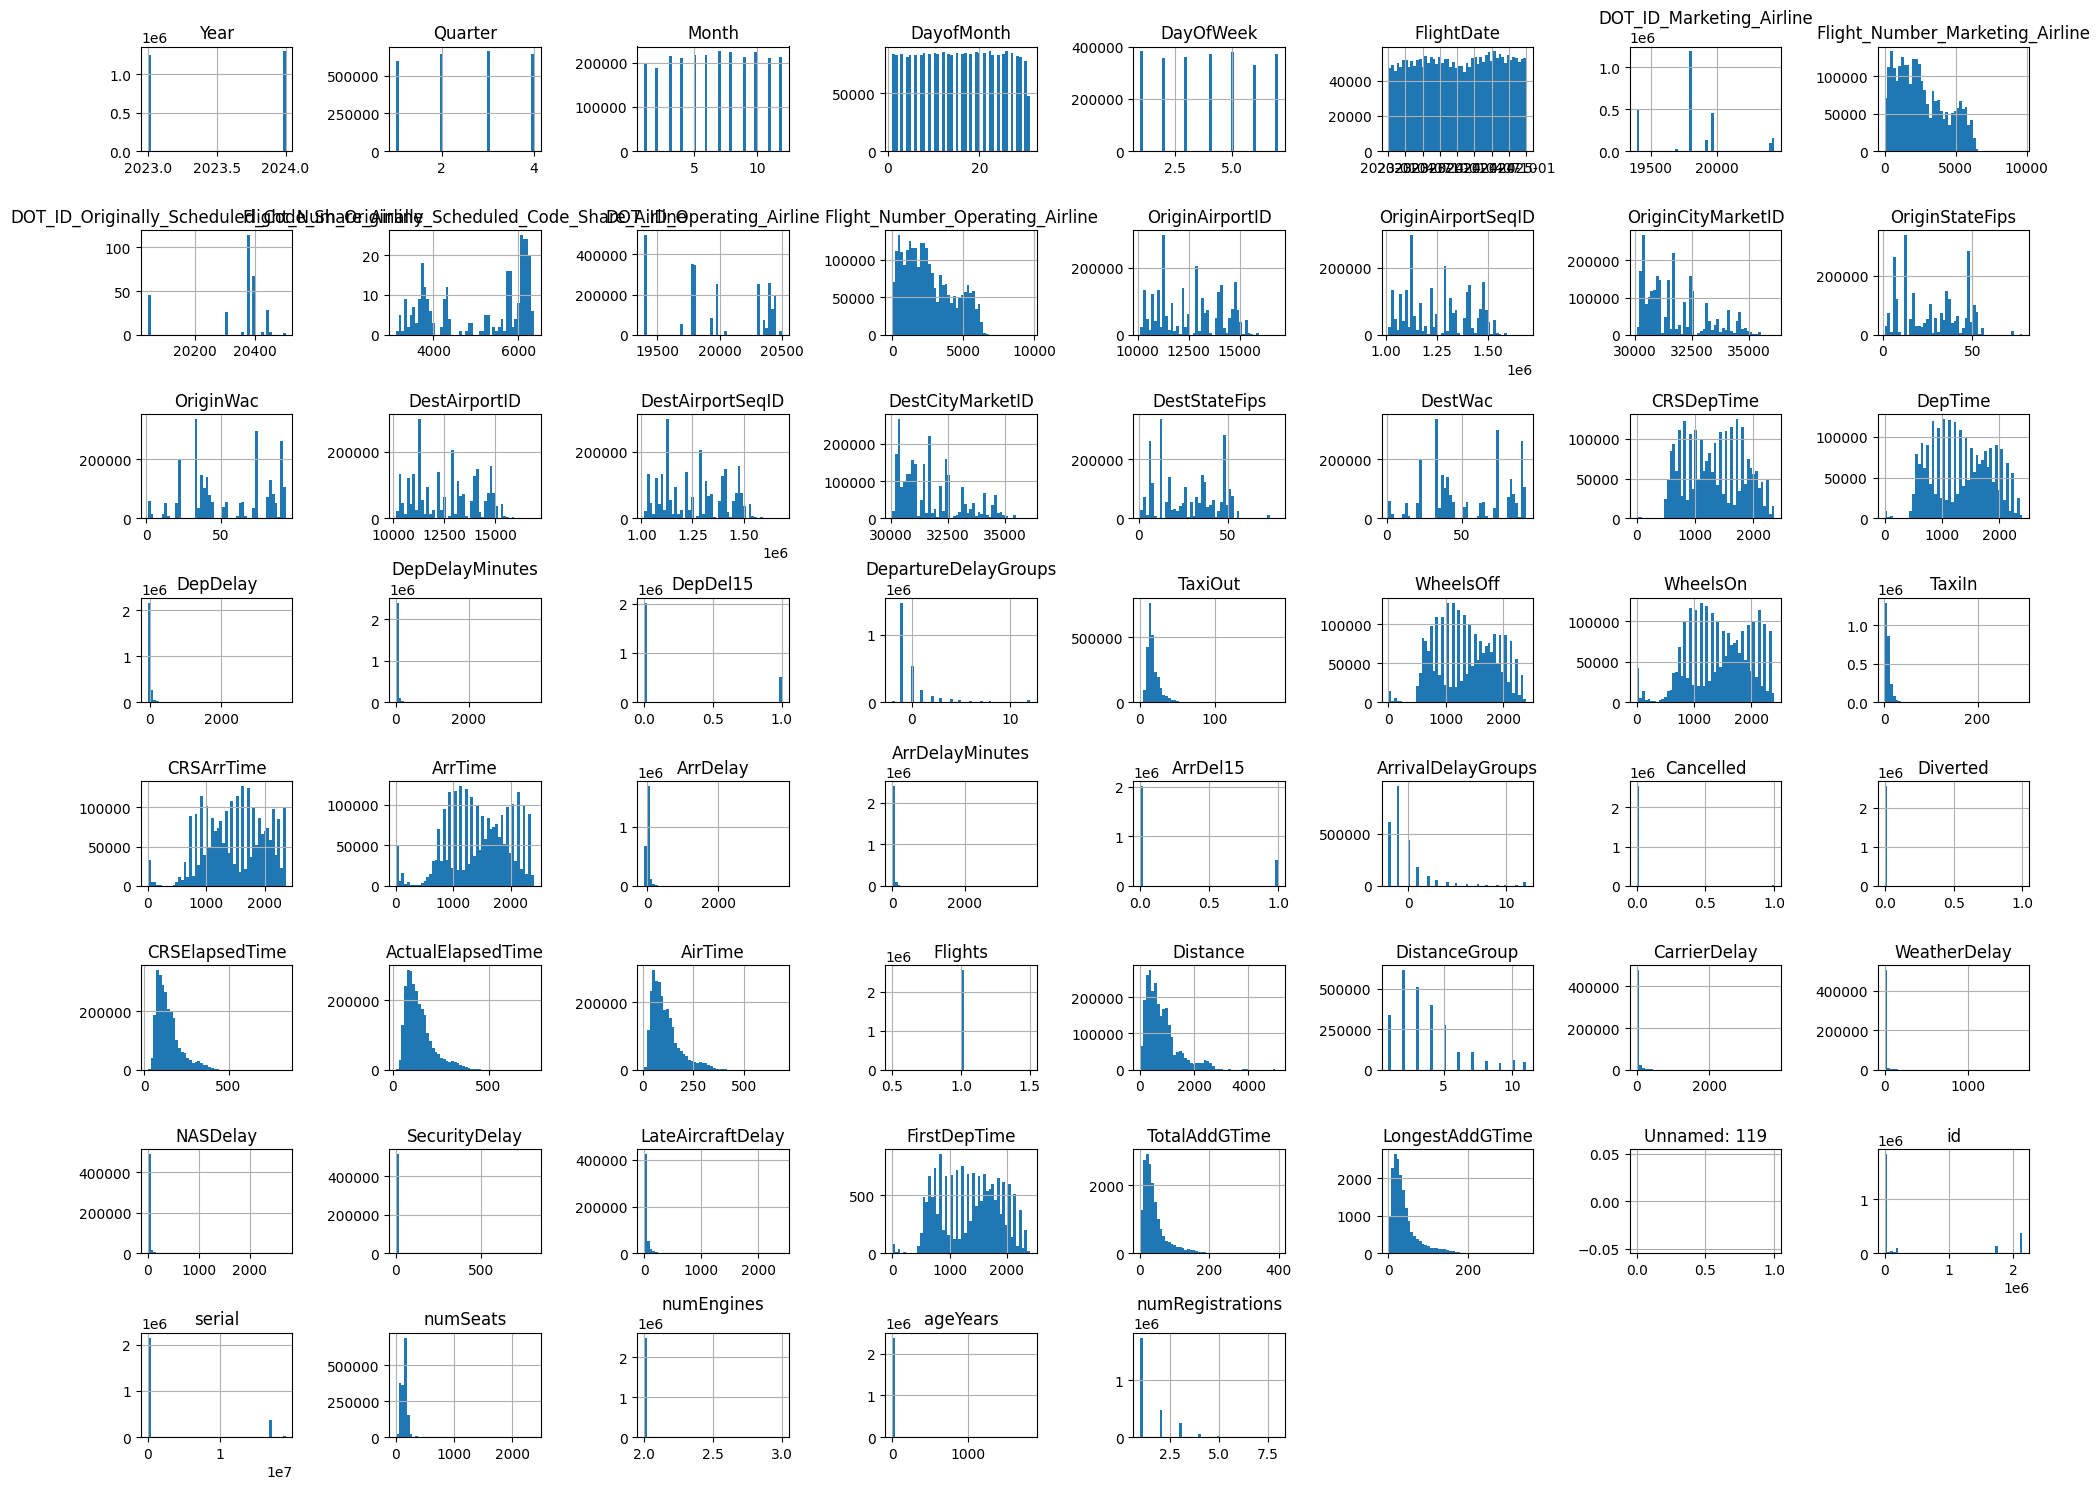

In [13]:
train_data.hist(bins=50, figsize=(20,15))
plt.tight_layout()

Aircrafts
==============

In [14]:

# train_data["VELOCITY"] = train_data["DISTANCE"] / train_data["AIR_TIME"]
# # remove infinite values
# flight_data = train_data[train_data["VELOCITY"] != float('inf')]
# flight_data["VELOCITY"].describe()

In [15]:
# aircrafts_velo_dist = list()
# aircrafts_dist_time = list()
# aircrafts_velo_time = list()
# for aircraft in flight_data["AIRCRAFT_TYPE"].unique():
#     aircraft_data = flight_data[flight_data["AIRCRAFT_TYPE"] == aircraft]
#     corr_matrix = aircraft_data[["VELOCITY", "DISTANCE"]].corr()
#     aircrafts_velo_dist.append((aircraft, corr_matrix["DISTANCE"]["VELOCITY"]))
#     aircrafts_dist_time.append((aircraft, corr_matrix["DISTANCE"]["AIR_TIME"]))
#     aircrafts_velo_time.append((aircraft, corr_matrix["VELOCITY"]["AIR_TIME"]))
# # bar graph of aircrafts
# aircrafts = pd.DataFrame(aircrafts_velo_dist, columns=["AIRCRAFT_TYPE", "CORR"])
# seaborn.barplot(x="AIRCRAFT_TYPE", y="CORR", data=aircrafts)
# aircrafts = pd.DataFrame(aircrafts_velo_time, columns=["AIRCRAFT_TYPE", "CORR"])
# seaborn.barplot(x="AIRCRAFT_TYPE", y="CORR", data=aircrafts)
# aircrafts = pd.DataFrame(aircrafts_dist_time, columns=["AIRCRAFT_TYPE", "CORR"])
# seaborn.barplot(x="AIRCRAFT_TYPE", y="CORR", data=aircrafts)


- Some aircrafts are well correlated with distance and others are not
- we could categorize these air crafts
- most aircrafts go slower the longer the air time
- longer distances are done at faster speeds for most aircrafts

## Time of Year/ Seasonality

/var/folders/2x/l1xq08kx17d7cfwdxb2by1lh0000gn/T/ipykernel_89695/2305699244.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.countplot(x="Month", data=train_data, palette="Blues")


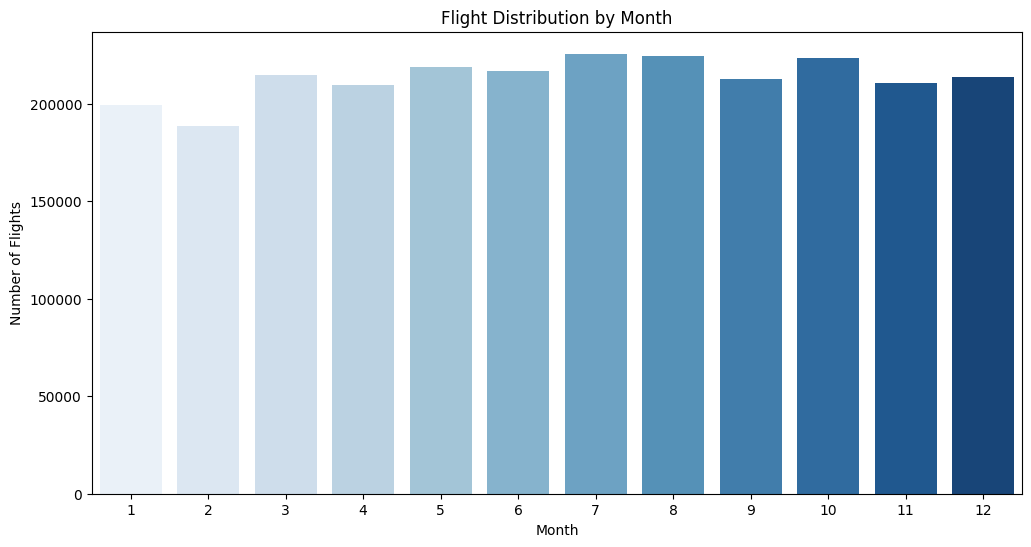

/var/folders/2x/l1xq08kx17d7cfwdxb2by1lh0000gn/T/ipykernel_89695/2305699244.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.countplot(x="DayOfWeek", data=train_data, palette="Blues")


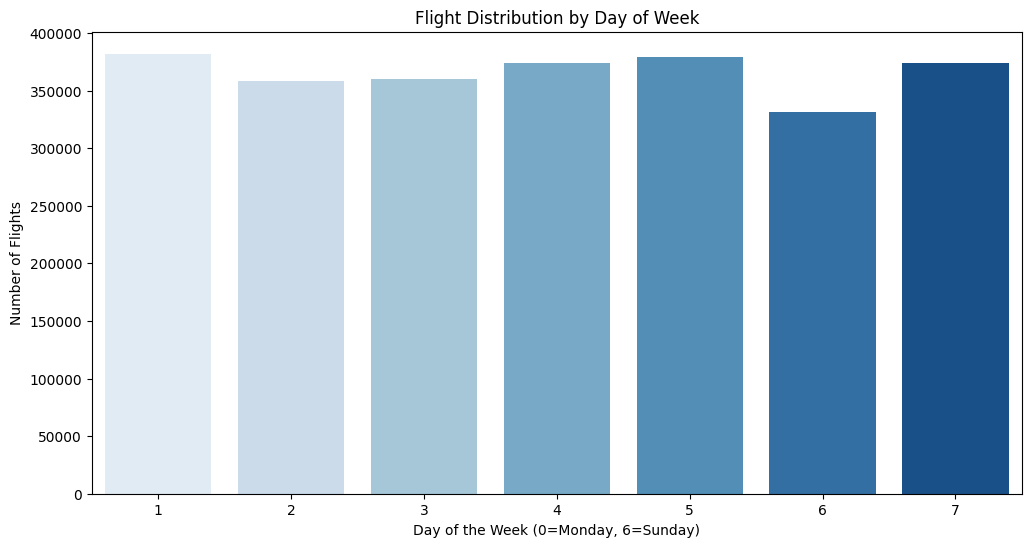

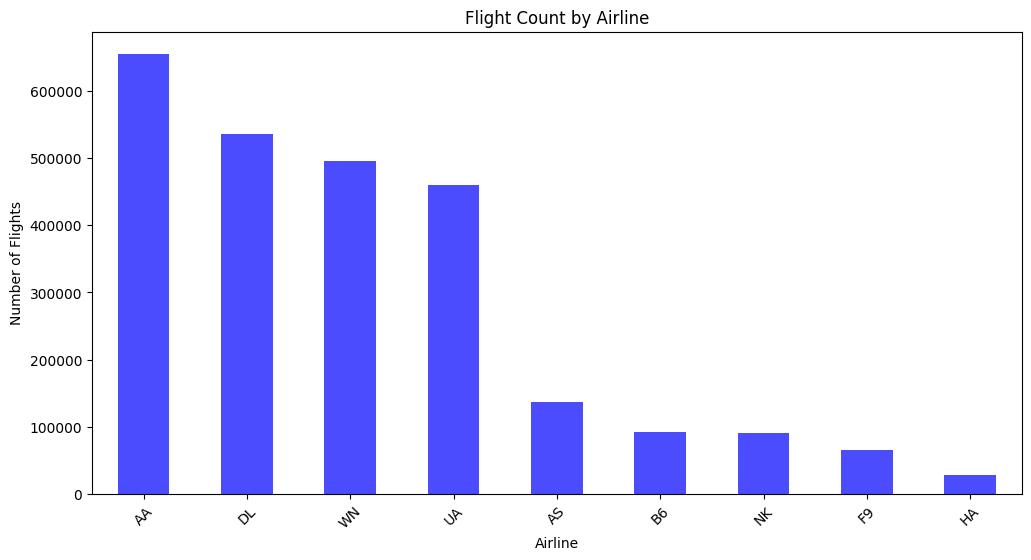

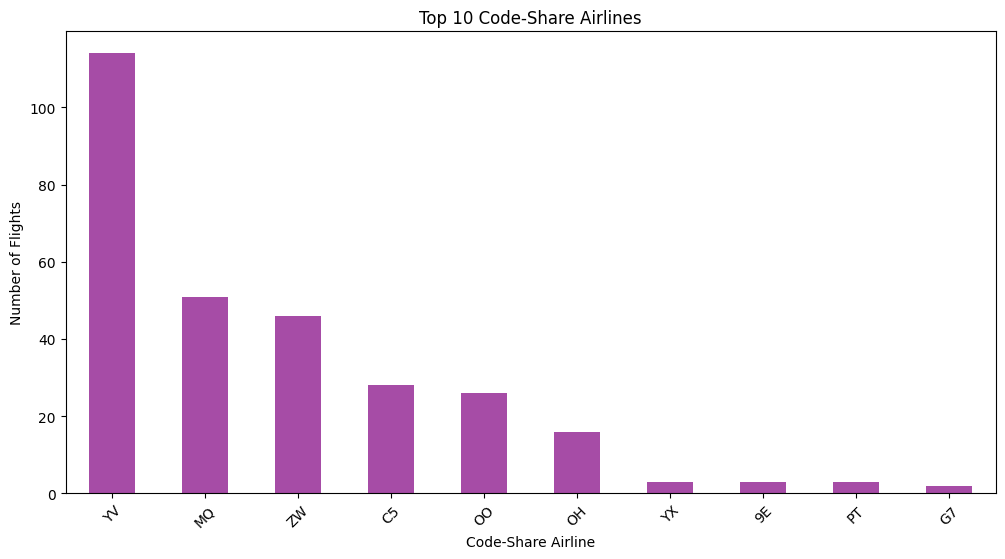

In [16]:
# Convert relevant columns to categorical data types
categorical_cols = ["Marketing_Airline_Network", "Origin", "OriginCityName"]
train_data[categorical_cols] = train_data[categorical_cols].astype("category")
categorical_cols.append("Operating_Airline")
### 1. Temporal Patterns (Delays by Time of Year, Month, Day) ###
plt.figure(figsize=(12, 6))
seaborn.countplot(x="Month", data=train_data, palette="Blues")
plt.title("Flight Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Number of Flights")
plt.show()

plt.figure(figsize=(12, 6))
seaborn.countplot(x="DayOfWeek", data=train_data, palette="Blues")
plt.title("Flight Distribution by Day of Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Flights")
plt.show()

### 2. Airline Performance (Delays by Airline) ###
plt.figure(figsize=(12, 6))
train_data["Marketing_Airline_Network"].value_counts().plot(kind="bar", color="blue", alpha=0.7)
plt.title("Flight Count by Airline")
plt.xlabel("Airline")
plt.ylabel("Number of Flights")
plt.xticks(rotation=45)
plt.show()


### 4. Identifying Seasonal Trends in Delays ###
# Assuming you have a column `Delayed` where 1 = delayed, 0 = on-time
if "Delayed" in train_data.columns:
    monthly_delays = train_data.groupby("Month")["Delayed"].mean()
    plt.figure(figsize=(12, 6))
    seaborn.lineplot(x=monthly_delays.index, y=monthly_delays.values, marker="o", color="red")
    plt.title("Average Delay Rate by Month")
    plt.xlabel("Month")
    plt.ylabel("Proportion of Delayed Flights")
    plt.show()

### 5. Code-Share & Connection Issues ###
if "Originally_Scheduled_Code_Share_Airline" in train_data.columns:
    plt.figure(figsize=(12, 6))
    train_data["Originally_Scheduled_Code_Share_Airline"].value_counts().nlargest(10).plot(kind="bar", color="purple", alpha=0.7)
    plt.title("Top 10 Code-Share Airlines")
    plt.xlabel("Code-Share Airline")
    plt.ylabel("Number of Flights")
    plt.xticks(rotation=45)
    plt.show()

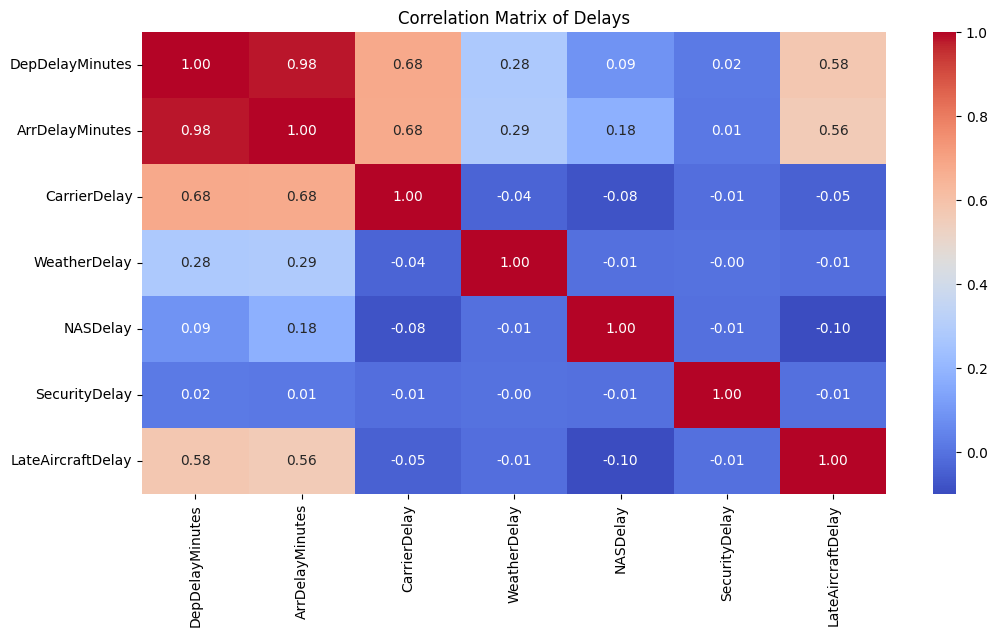

In [17]:
### 6. Heatmap for different delays as x axis and other columns as y axis ###
delays = ['DepDelayMinutes', 'ArrDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

# Create a correlation matrix
corr_matrix = train_data[delays].corr()

# Plot the heatmap
plt.figure(figsize=(12, 6))
seaborn.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Delays")
plt.show()



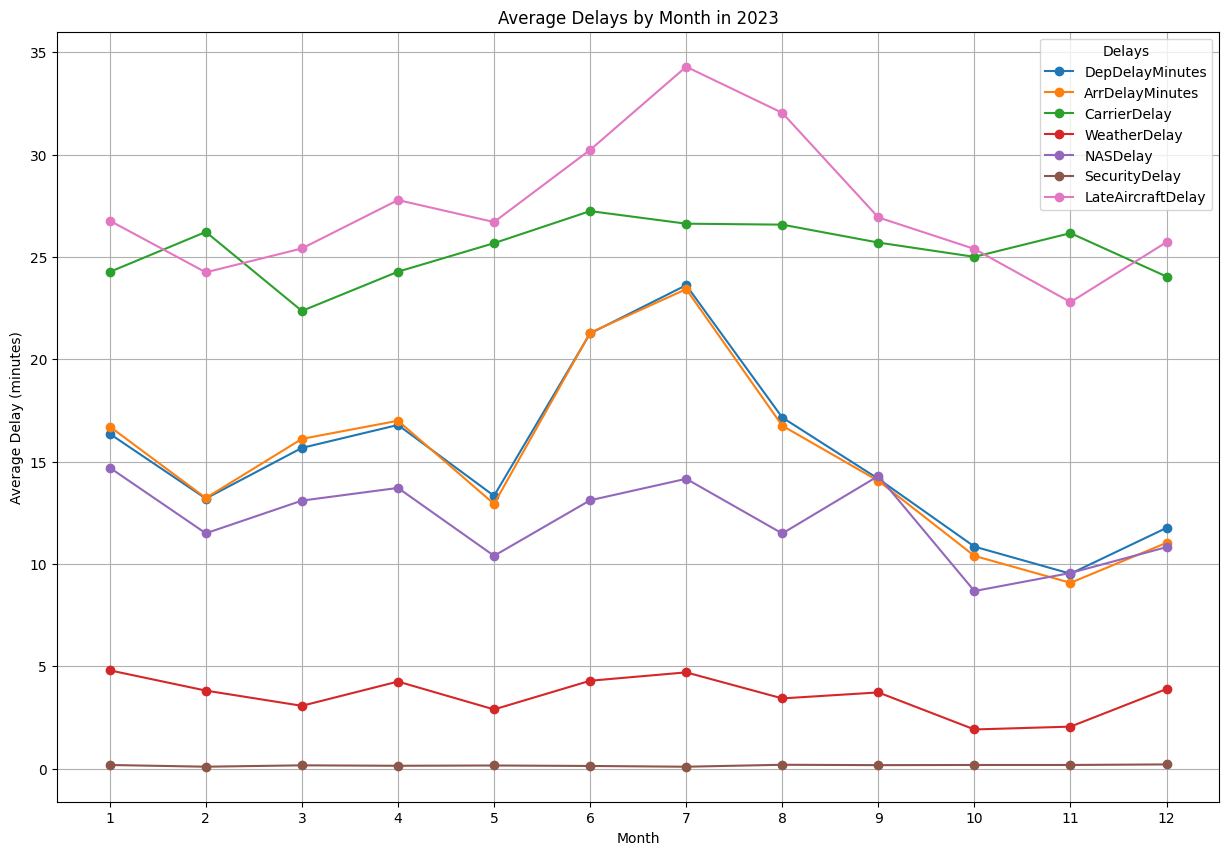

In [18]:
# 2023 seasonal trends with delays

delays = ['DepDelayMinutes', 'ArrDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

# Filter the data for 2023
data_2023 = train_data[train_data["Year"] == 2023]

# Calculate the average delays for each month
monthly_delays = data_2023.groupby("Month")[delays].mean()

# Plot the average delays for each month
plt.figure(figsize=(15, 10))
monthly_delays.plot(kind="line", marker="o", ax=plt.gca())
plt.title("Average Delays by Month in 2023")
plt.xlabel("Month")
plt.ylabel("Average Delay (minutes)")
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(title="Delays")
plt.show()



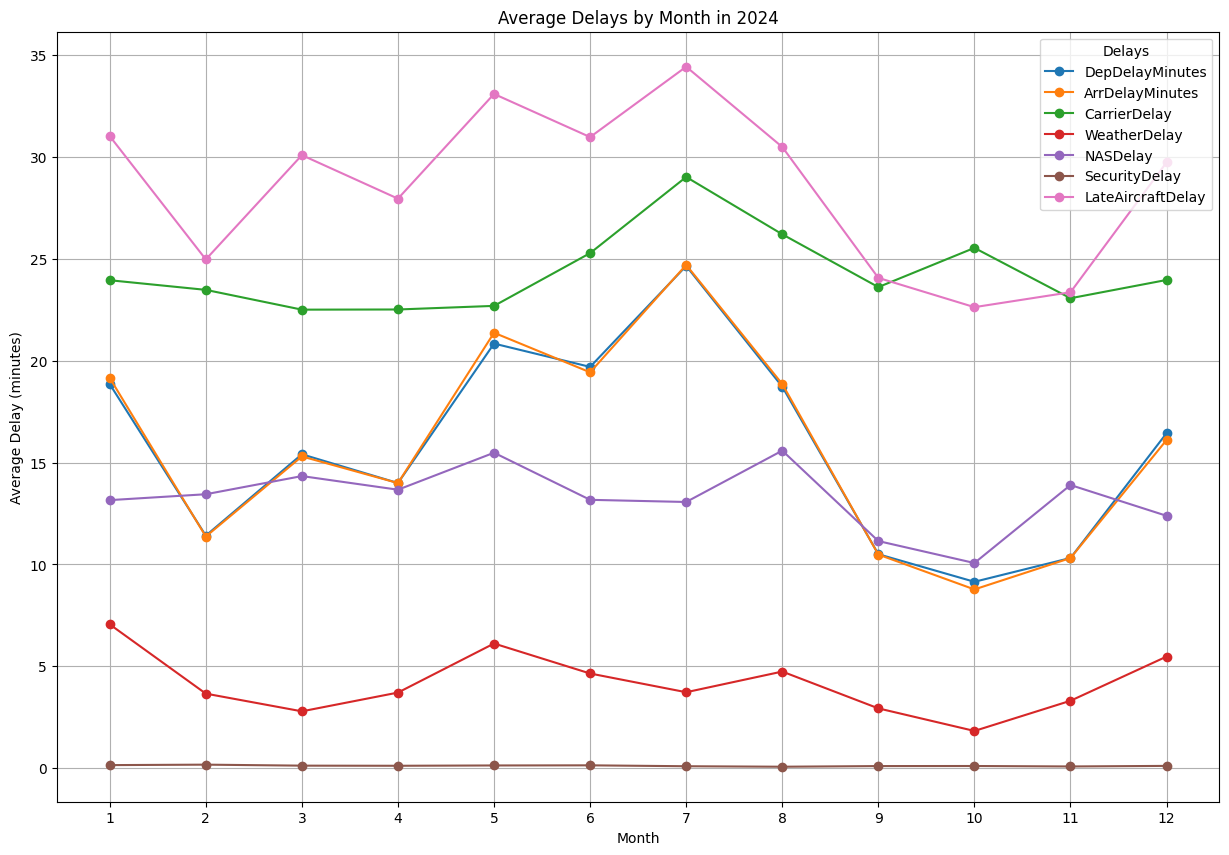

In [19]:
# Filter the data for 2024
data_2024 = train_data[train_data["Year"] == 2024]

# Calculate the average delays for each month
monthly_delays = data_2024.groupby("Month")[delays].mean()

# Plot the average delays for each month
plt.figure(figsize=(15, 10))
monthly_delays.plot(kind="line", marker="o", ax=plt.gca())
plt.title("Average Delays by Month in 2024")
plt.xlabel("Month")
plt.ylabel("Average Delay (minutes)")
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(title="Delays")
plt.show()

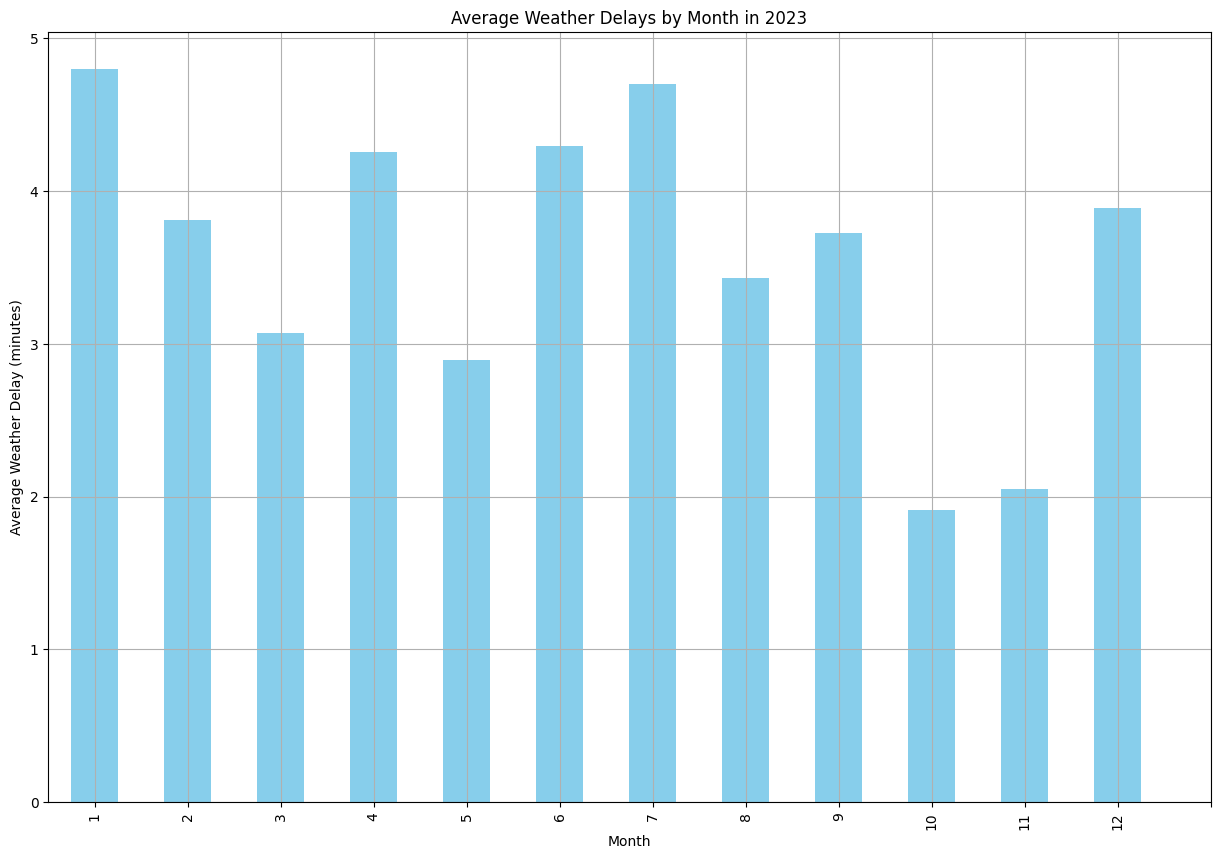

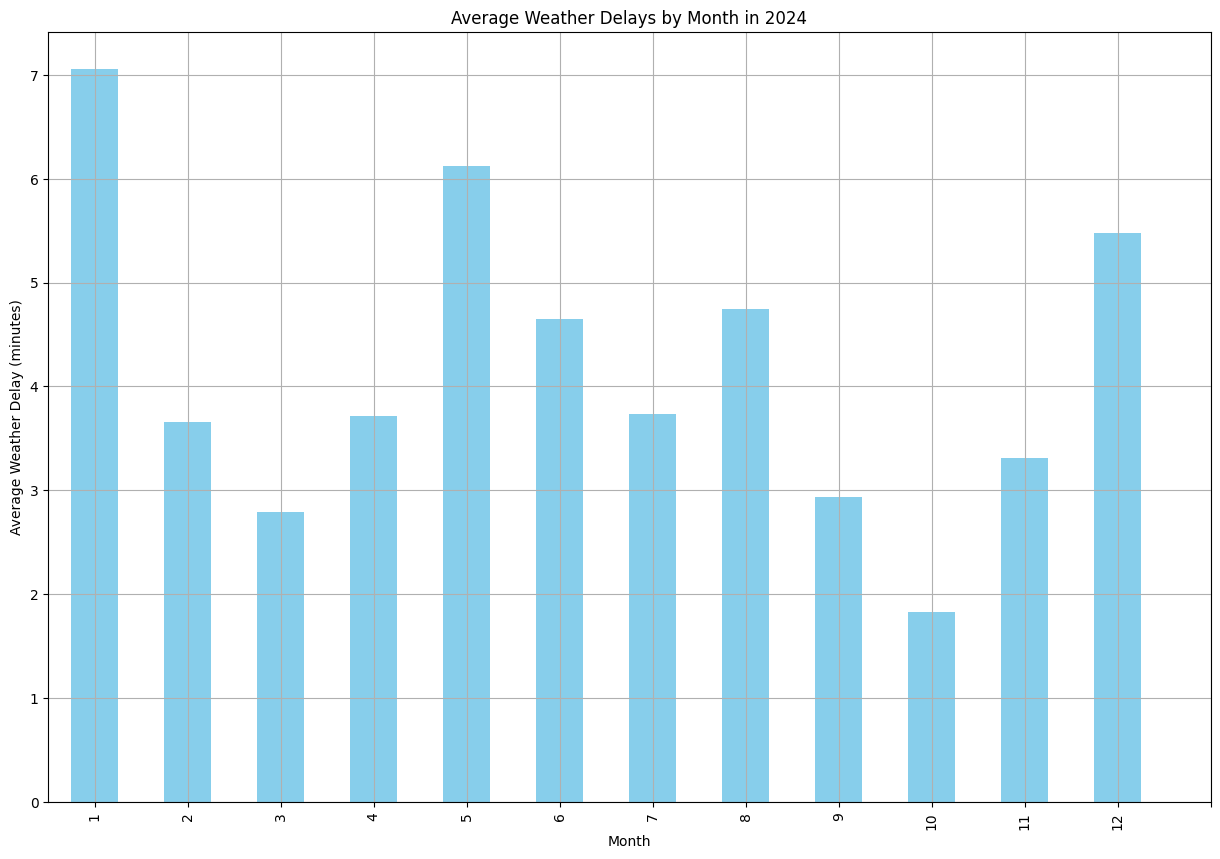

In [20]:
# Map weather delays in 2023 with a histogram

# Filter the data for 2023
data_2023 = train_data[train_data["Year"] == 2023]

# Calculate the average weather delays for each month
monthly_weather_delays = data_2023.groupby("Month")["WeatherDelay"].mean()

# Plot the average weather delays for each month
plt.figure(figsize=(15, 10))
monthly_weather_delays.plot(kind="bar", ax=plt.gca(), color="skyblue")
plt.title("Average Weather Delays by Month in 2023")
plt.xlabel("Month")
plt.ylabel("Average Weather Delay (minutes)")
plt.xticks(range(0, 13))
plt.grid(True)
plt.show()

# Map weather delays in 2024 with a histogram

# Filter the data for 2024
data_2024 = train_data[train_data["Year"] == 2024]

# Calculate the average weather delays for each month
monthly_weather_delays = data_2024.groupby("Month")["WeatherDelay"].mean()

# Plot the average weather delays for each month
plt.figure(figsize=(15, 10))
monthly_weather_delays.plot(kind="bar", ax=plt.gca(), color="skyblue")
plt.title("Average Weather Delays by Month in 2024")
plt.xlabel("Month")
plt.ylabel("Average Weather Delay (minutes)")
plt.xticks(range(0, 13))
plt.grid(True)
plt.show()



In [21]:
train_data['DepHourofDay'] = (data['CRSDepTime']//100)

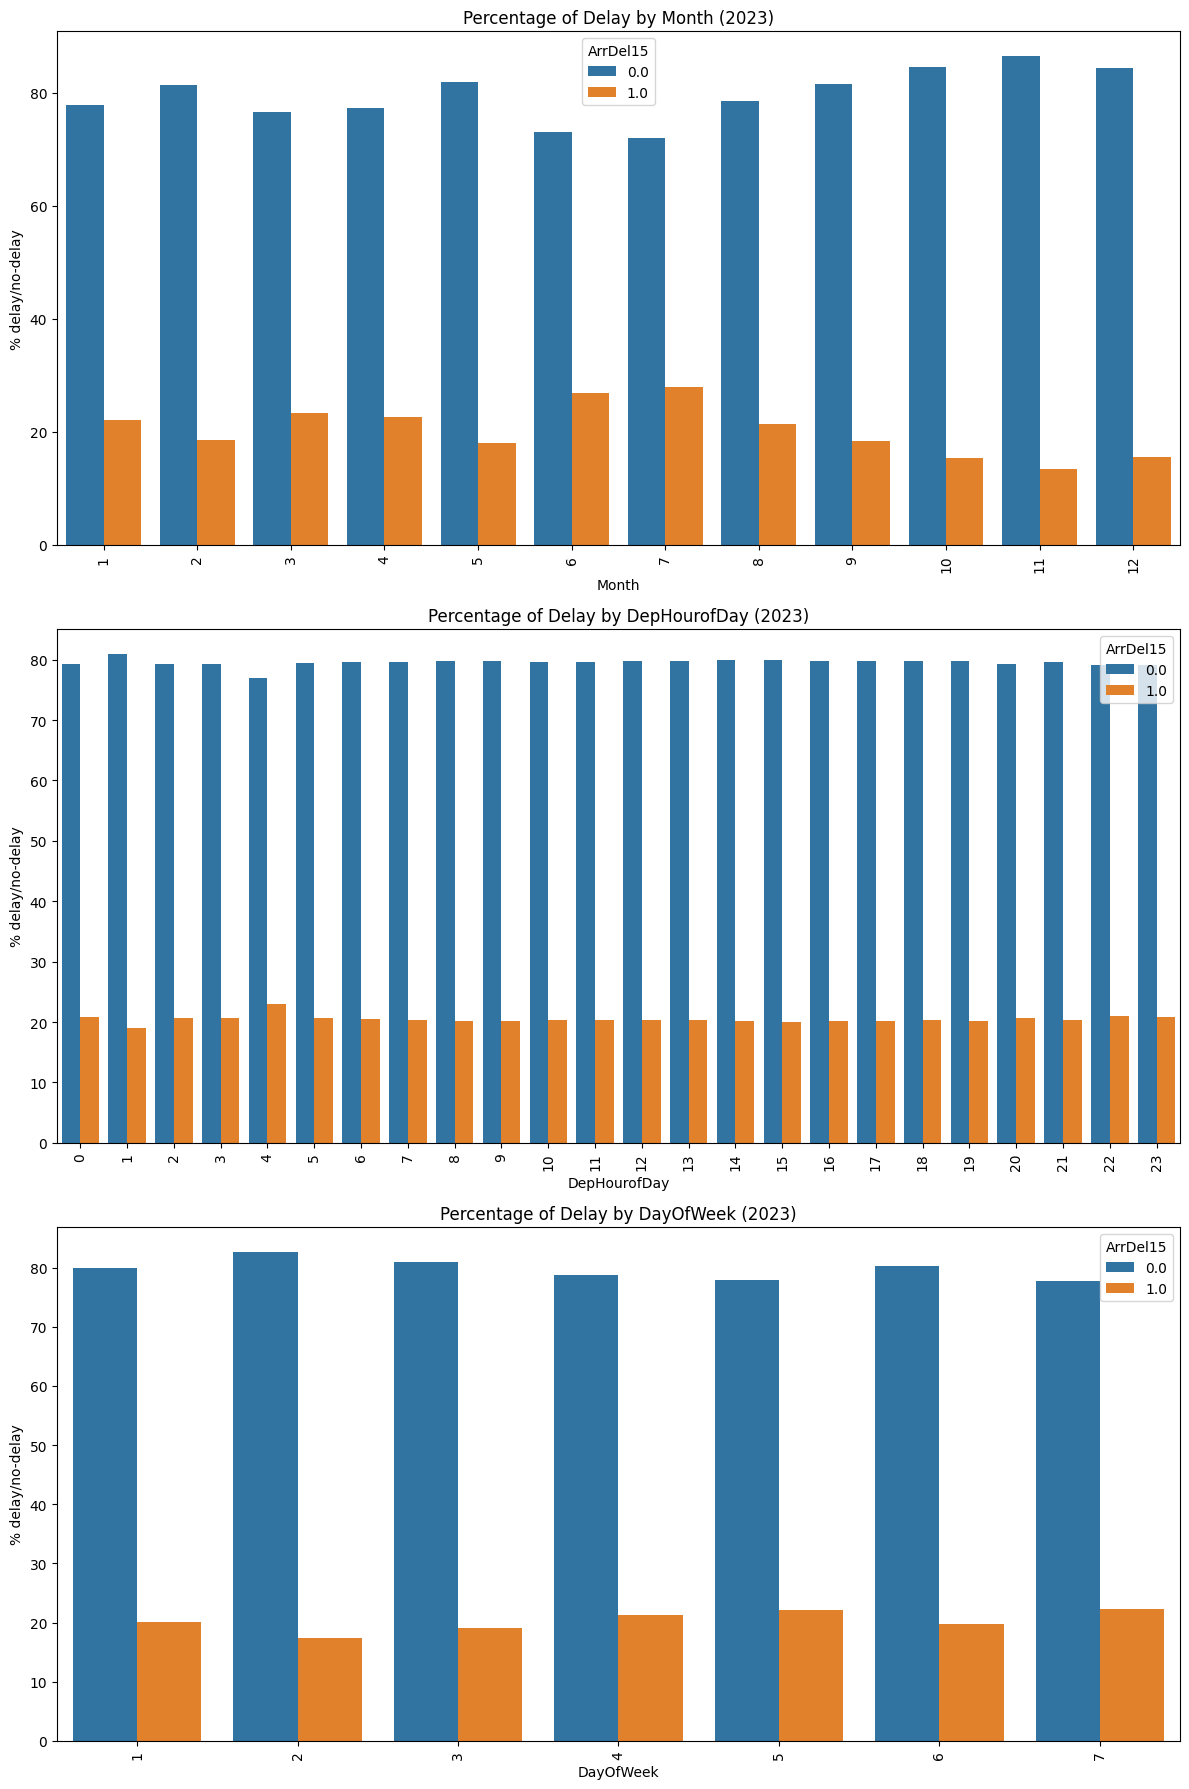

In [22]:

# Filter data for 2023
train_data_2023 = train_data[train_data['Year'] == 2023]

# Select three columns for visualization
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek']

# Create subplots with 3 rows and 1 column
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

for idx, column in enumerate(viz_columns):
    ax = axes[idx]
    
    # Group data by column and calculate delay percentages
    temp = train_data_2023.groupby(column)['ArrDel15'].value_counts(normalize=True).rename('percentage') \
        .mul(100).reset_index().sort_values(column)
    
    # Create bar plots
    seaborn.barplot(x=column, y="percentage", hue="ArrDel15", data=temp, ax=ax)
    ax.set_ylabel('% delay/no-delay')
    ax.set_xlabel(column)
    ax.set_title(f'Percentage of Delay by {column} (2023)')
    ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()


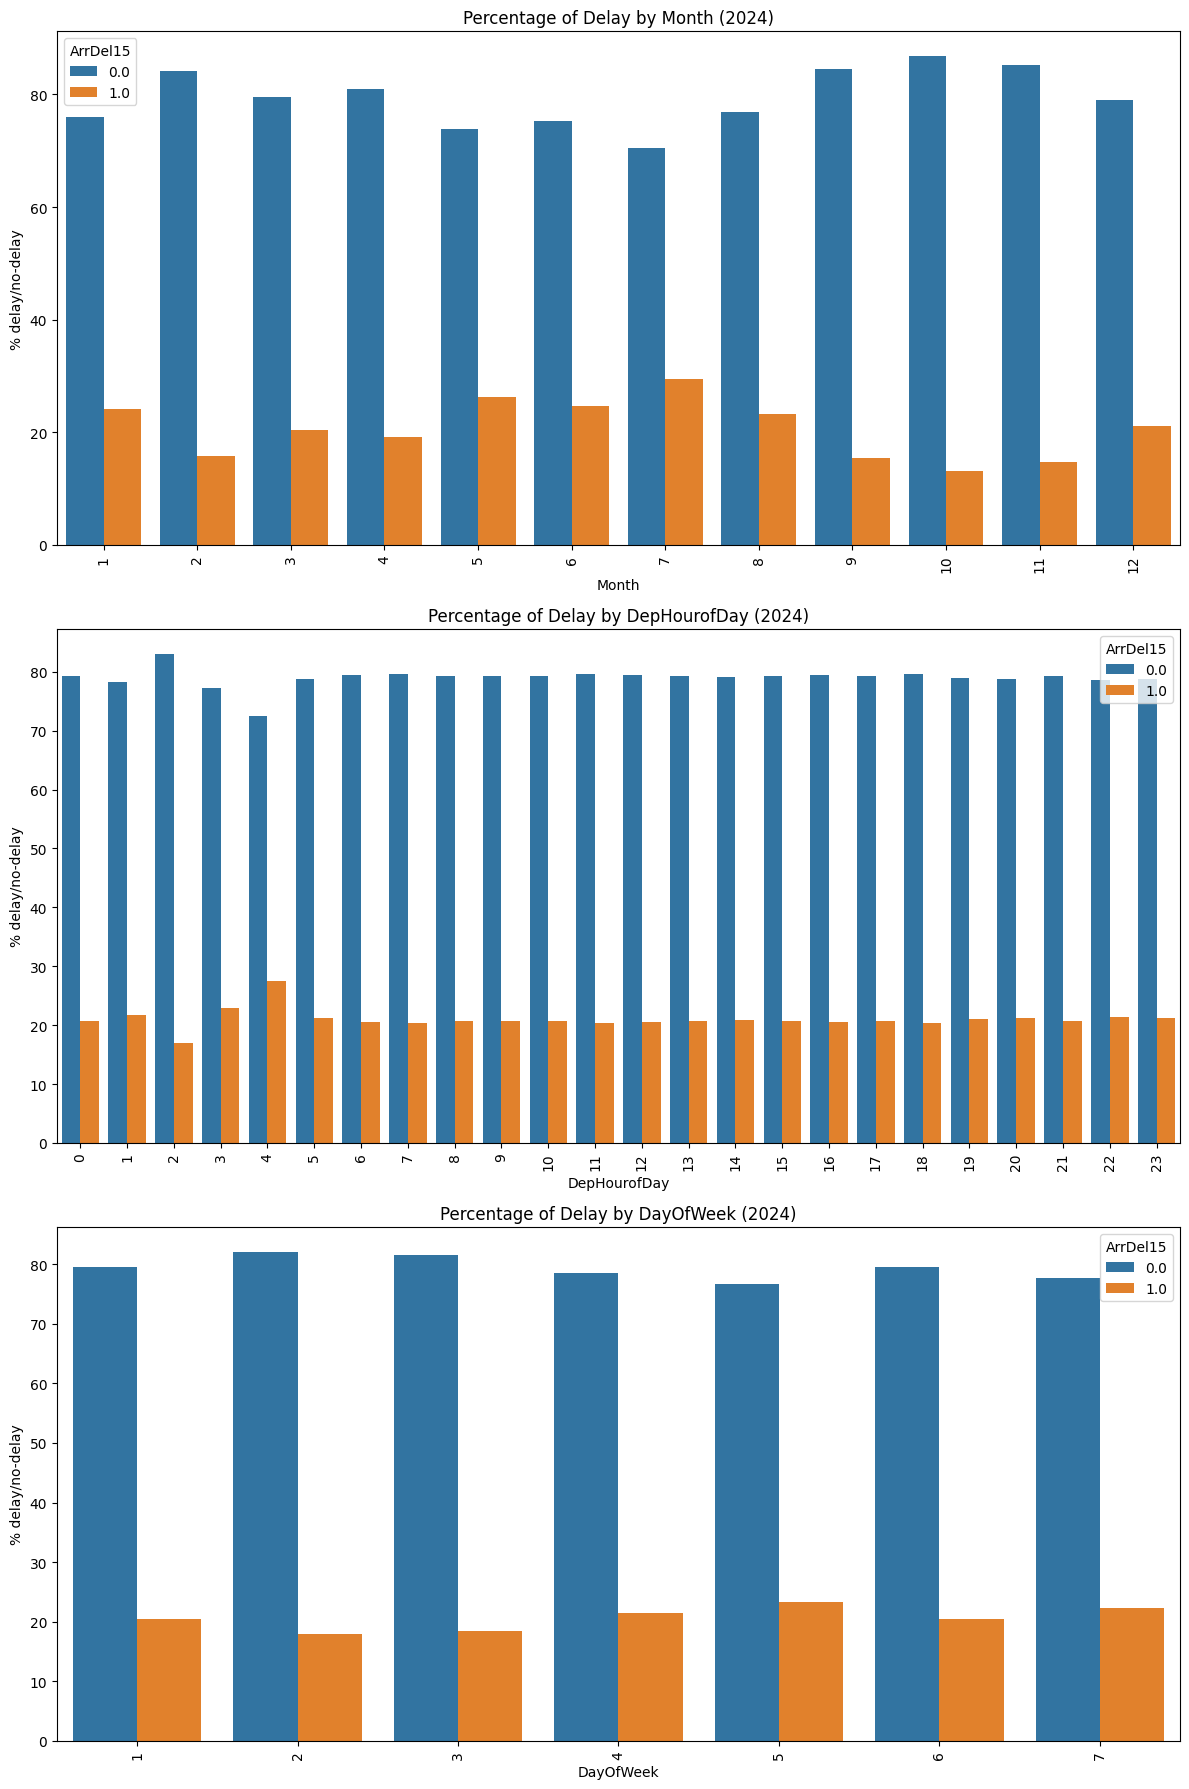

In [23]:
# Filter data for 2024
train_data_2023 = train_data[train_data['Year'] == 2024]

# Select three columns for visualization
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek']

# Create subplots with 3 rows and 1 column
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

for idx, column in enumerate(viz_columns):
    ax = axes[idx]
    
    # Group data by column and calculate delay percentages
    temp = train_data_2023.groupby(column)['ArrDel15'].value_counts(normalize=True).rename('percentage') \
        .mul(100).reset_index().sort_values(column)
    
    # Create bar plots
    seaborn.barplot(x=column, y="percentage", hue="ArrDel15", data=temp, ax=ax)
    ax.set_ylabel('% delay/no-delay')
    ax.set_xlabel(column)
    ax.set_title(f'Percentage of Delay by {column} (2024)')
    ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

ArrDel15  Season  Year        0.0        1.0
0           Fall  2023  84.251676  15.748324
1           Fall  2024  85.585511  14.414489
2         Spring  2023  78.654649  21.345351
3         Spring  2024  78.018404  21.981596
4         Summer  2023  74.619224  25.380776


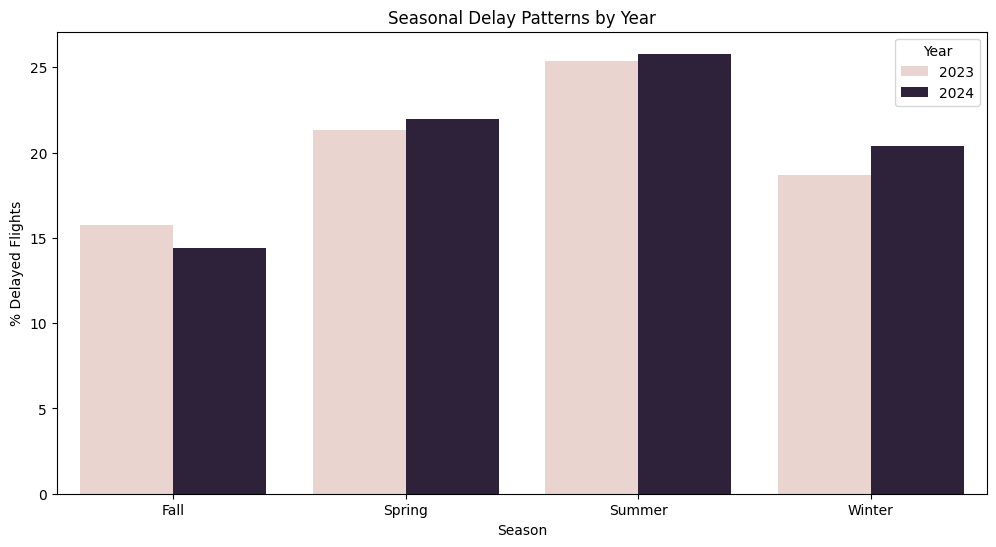

In [24]:
# 2023 seasonal trends


# Function to categorize months into seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Add a column to categorize the months into seasons
train_data['Season'] = train_data['Month'].apply(get_season)

# Filter data for 2023 and 2024 to focus on these years
train_data_filtered = train_data[train_data['Year'].isin([2023, 2024])]

# Group data by season and calculate the count of delays and non-delays
season_delay_data = train_data_filtered.groupby(['Season', 'Year', 'ArrDel15']).size().unstack(fill_value=0)

# Calculate the percentage of delays and non-delays by season
season_delay_data_percentage = season_delay_data.div(season_delay_data.sum(axis=1), axis=0) * 100

# Reset the index to flatten the DataFrame
season_delay_data_percentage = season_delay_data_percentage.reset_index()

# Check the structure of the data
print(season_delay_data_percentage.head())

# Create a plot for seasonal delay patterns
plt.figure(figsize=(12, 6))

# Now, plot the 'Delayed' column (adjusted to your actual delay label)
seaborn.barplot(x='Season', y=1, hue='Year', data=season_delay_data_percentage)

plt.title('Seasonal Delay Patterns by Year')
plt.ylabel('% Delayed Flights')
plt.xlabel('Season')
plt.legend(title='Year')
plt.show()


- Seemingly the Summer is when

## Aircraft vs Delays

In [25]:
train_data.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,numEngines,engineType,isFreighter,productionLine,ageYears,verified,numRegistrations,firstRegistrationDate,DepHourofDay,Season
3871298,2023,3,7,24,1,2023-07-24,AA,AA_CODESHARE,19805,AA,...,2.0,Jet,False,Embraer ERJ170,11.6,True,1,2013-09-19,13,Summer
7435846,2024,1,1,25,4,2024-01-25,AA,AA,19805,AA,...,2.0,Jet,False,Airbus A321 NEO,2.6,True,1,NaN,8,Winter
7392932,2024,1,1,23,2,2024-01-23,WN,WN,19393,WN,...,2.0,Jet,False,Boeing 737 NG,21.9,True,3,2003-05-30,6,Winter
7165806,2024,1,1,10,3,2024-01-10,AA,AA_CODESHARE,19805,AA,...,2.0,Jet,False,Embraer ERJ170,6.0,True,1,2019-05-17,19,Winter
6271155,2023,4,11,24,5,2023-11-24,UA,UA,19977,UA,...,2.0,Jet,False,Airbus A320,23.6,True,3,2001-12-13,15,Fall


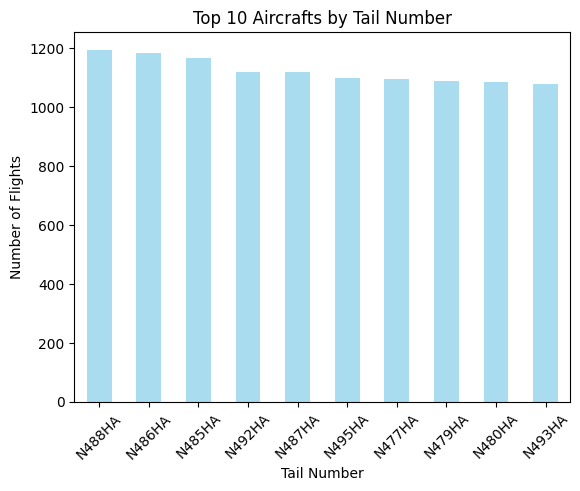

In [26]:
# Graph the aircrafts by tail number

train_data['Tail_Number'].value_counts().nlargest(10).plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Top 10 Aircrafts by Tail Number')
plt.xlabel('Tail Number')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()


In [44]:
# Major delay is 3hr or more
train_data['MajorDelay'] = train_data['ArrDelayMinutes'] >= 180

# minor delay is 15-16 min
train_data['MinorDelay'] = (train_data['ArrDelayMinutes'] >= 15) & (train_data['ArrDelayMinutes'] < 180)

# No delay
train_data['NoDelay'] = train_data['ArrDelayMinutes'] < 15

# drop planes with no delay
train_data = train_data[train_data['NoDelay'] != 0]

# medium delay is more than 16 min less than 3 hr
# train_data['MediumDelay'] = (train_data['ArrDelayMinutes'] >= 15) & (train_data['ArrDelayMinutes'] < 180)

In [ ]:
# Drop Tail_Number with no delay
# train_data = train_data[train_data['NoDelay'] == 0]

In [47]:
train_data.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,engineType,isFreighter,productionLine,ageYears,verified,numRegistrations,firstRegistrationDate,MajorDelay,MinorDelay,NoDelay
3871298,2023,3,7,24,1,2023-07-24,AA,AA_CODESHARE,19805,AA,...,Jet,False,Embraer ERJ170,11.6,True,1,2013-09-19,False,False,True
7435846,2024,1,1,25,4,2024-01-25,AA,AA,19805,AA,...,Jet,False,Airbus A321 NEO,2.6,True,1,NaN,False,False,True
7392932,2024,1,1,23,2,2024-01-23,WN,WN,19393,WN,...,Jet,False,Boeing 737 NG,21.9,True,3,2003-05-30,False,False,True
7165806,2024,1,1,10,3,2024-01-10,AA,AA_CODESHARE,19805,AA,...,Jet,False,Embraer ERJ170,6.0,True,1,2019-05-17,False,False,True
10108038,2024,2,6,11,2,2024-06-11,DL,DL,19790,DL,...,Jet,False,Boeing 737 NG,11.5,True,1,2013-10-03,False,False,True


In [50]:
# # Plot planes with only minor delays
# train_data[train_data['MinorDelay'] == 1]['Tail_Number'].value_counts().nlargest(50).plot(kind='bar', color='skyblue', alpha=0.7)
# plt.title('Top 10 Aircrafts by Minor Delays')
# plt.xlabel('Tail Number')
# plt.ylabel('Number of Flights')
# plt.xticks(rotation=45)
# plt.show()

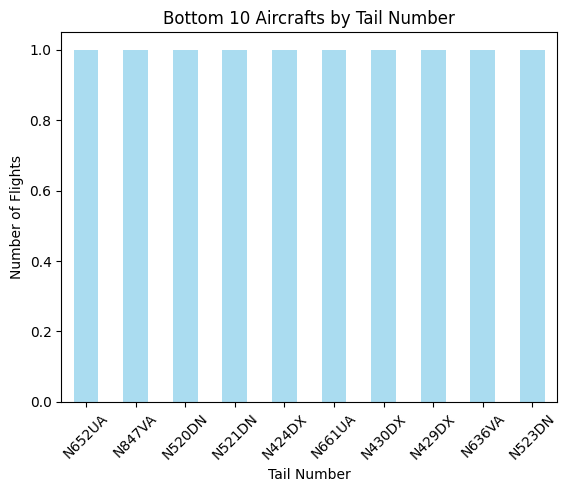

In [51]:
# Graph the lowest 10 aircrafts by tail number

train_data['Tail_Number'].value_counts().nsmallest(10).plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Bottom 10 Aircrafts by Tail Number')
plt.xlabel('Tail Number')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()

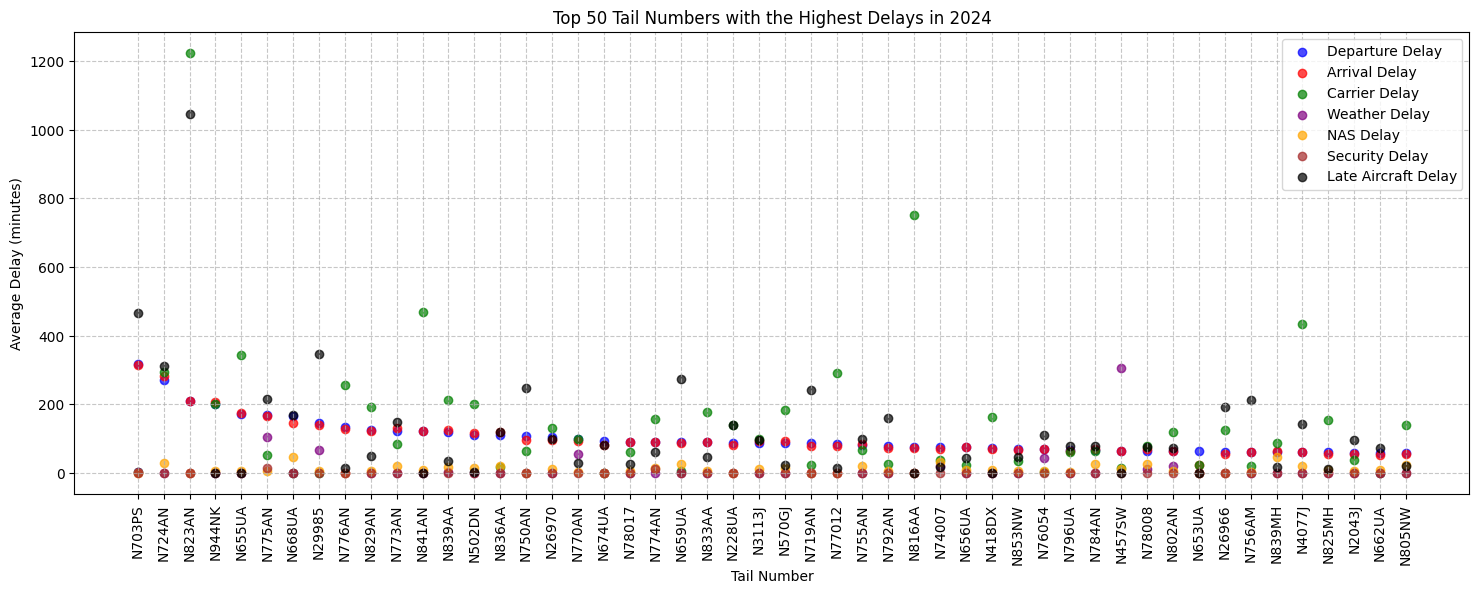

In [53]:

# Aggregate the data to get the average delays per tail number
tail_number_delays = data_2024.groupby("Tail_Number")[delays].mean()

# Sort by highest average delay
tail_number_delays = tail_number_delays.sort_values("DepDelayMinutes", ascending=False)

# Select the top 50 tail numbers with the highest departure delays
top_tail_numbers = tail_number_delays.head(50)

# Scatter plot
plt.figure(figsize=(18, 6))
plt.scatter(top_tail_numbers.index, top_tail_numbers["DepDelayMinutes"], color="blue", label="Departure Delay", alpha=0.7)
plt.scatter(top_tail_numbers.index, top_tail_numbers["ArrDelayMinutes"], color="red", label="Arrival Delay", alpha=0.7)
plt.scatter(top_tail_numbers.index, top_tail_numbers["CarrierDelay"], color="green", label="Carrier Delay", alpha=0.7)
plt.scatter(top_tail_numbers.index, top_tail_numbers["WeatherDelay"], color="purple", label="Weather Delay", alpha=0.7)
plt.scatter(top_tail_numbers.index, top_tail_numbers["NASDelay"], color="orange", label="NAS Delay", alpha=0.7)
plt.scatter(top_tail_numbers.index, top_tail_numbers["SecurityDelay"], color="brown", label="Security Delay", alpha=0.7)
plt.scatter(top_tail_numbers.index, top_tail_numbers["LateAircraftDelay"], color="black", label="Late Aircraft Delay", alpha=0.7)

# Improve readability
plt.xticks(rotation=90)
plt.xlabel("Tail Number")
plt.ylabel("Average Delay (minutes)")
plt.title("Top 50 Tail Numbers with the Highest Delays in 2024")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

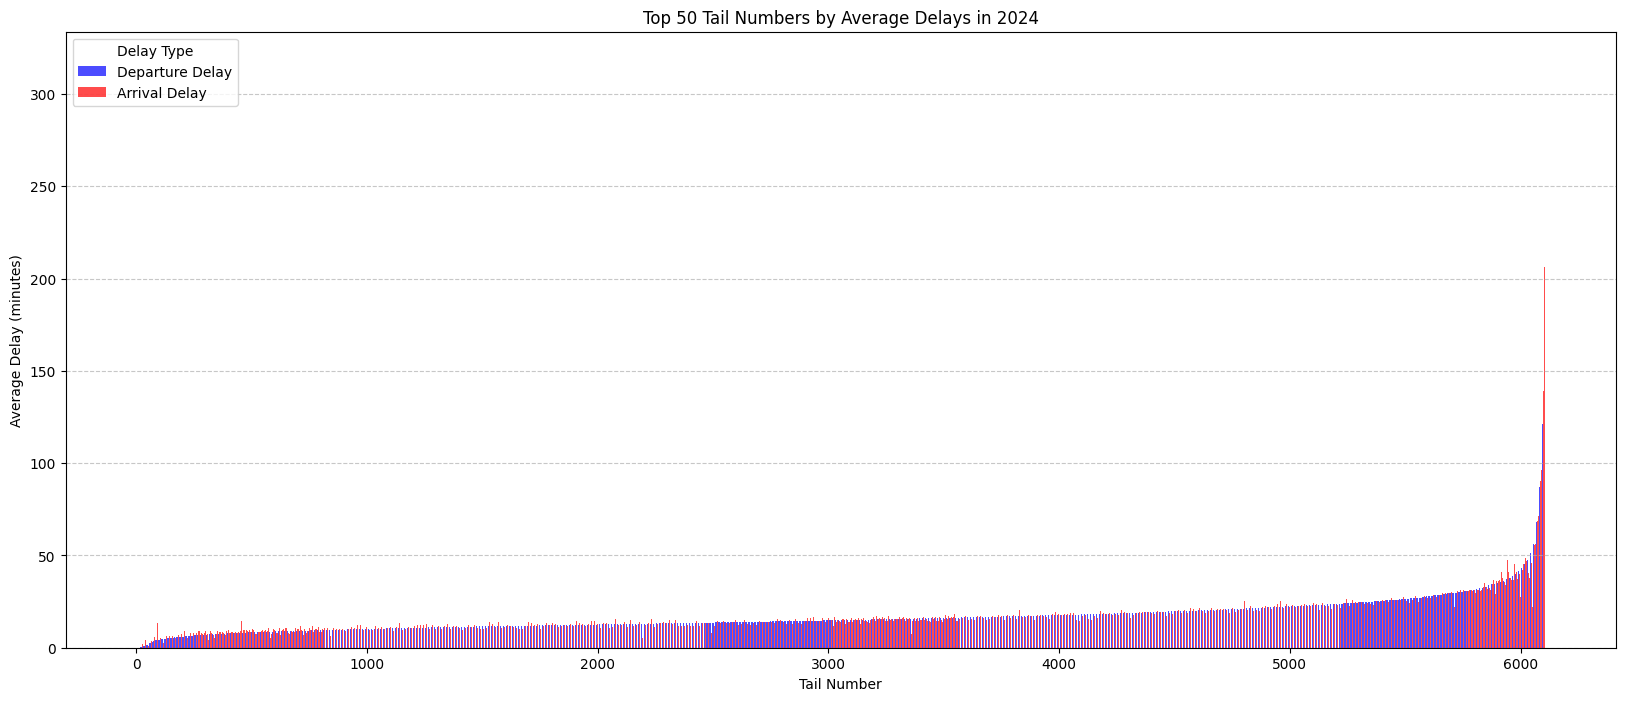

In [57]:
# Aggregate by Tail Number (or another category)
tail_number_delays = data_2024.groupby("Tail_Number")[delays].mean()

# Sort by average departure delay for better visualization
tail_number_delays = tail_number_delays.sort_values("DepDelayMinutes")

# Select the top 50 tail numbers for clarity
top_tail_numbers = tail_number_delays.head(50)

# Increase figure width for better spacing
plt.figure(figsize=(20, 8))  

# Set bar width
bar_width = 0.4  

# Create x positions
x = range(len(tail_number_delays))

# Plot side-by-side bars
plt.bar(x, tail_number_delays["DepDelayMinutes"], width=bar_width, label="Departure Delay", color="blue", alpha=0.7)
plt.bar([i + bar_width for i in x], tail_number_delays["ArrDelayMinutes"], width=bar_width, label="Arrival Delay", color="red", alpha=0.7)

# Improve x-axis labels
# plt.xticks([i + bar_width / 2 for i in x], top_tail_numbers.index, rotation=90)

plt.title("Top 50 Tail Numbers by Average Delays in 2024")
plt.ylabel("Average Delay (minutes)")
plt.xlabel("Tail Number")
plt.legend(title="Delay Type")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

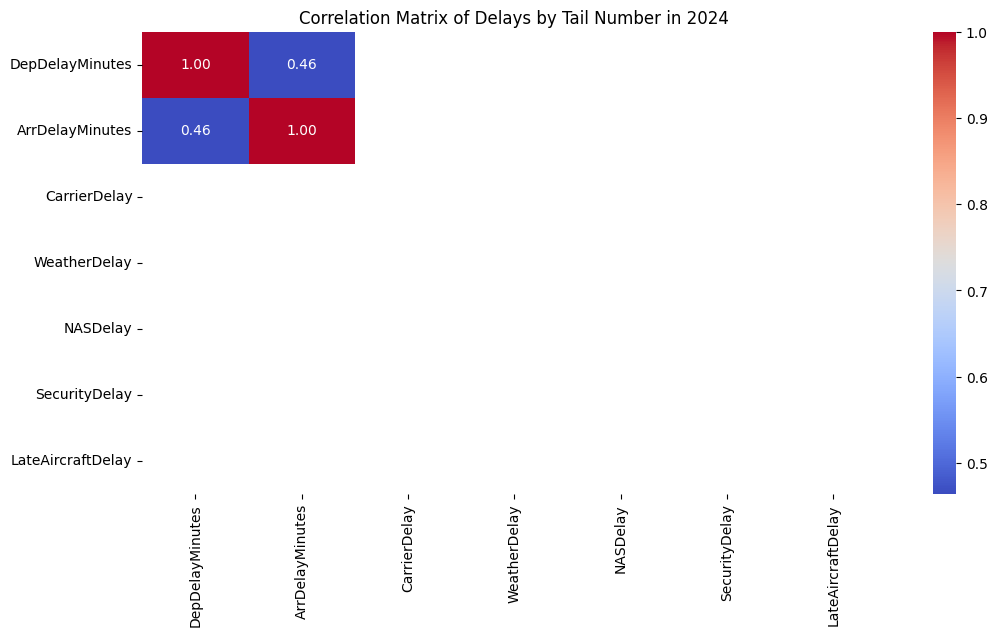

In [60]:
# Correlation between delays and Tail Number

# Filter the data for 2024

data_2024 = train_data[train_data["Year"] == 2024]

# Calculate the average delays for each tail number

tail_number_delays = data_2024.groupby("Tail_Number")[delays].mean()

# Calculate the correlation matrix

corr_matrix = tail_number_delays.corr()

# Plot the heatmap

plt.figure(figsize=(12, 6))

seaborn.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Correlation Matrix of Delays by Tail Number in 2024")

plt.show()



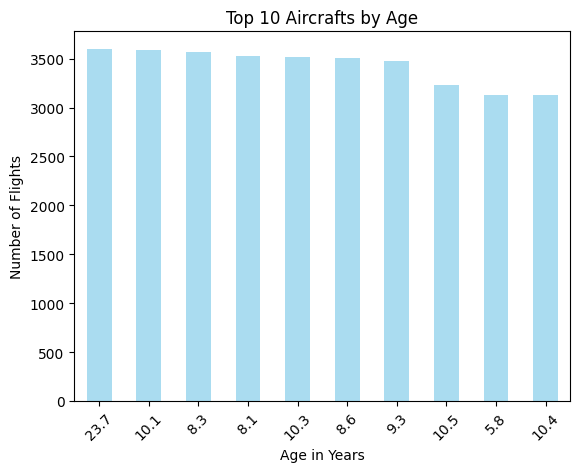

In [ ]:
# Graph the aircrafts with the highest age

train_data['ageYears'].value_counts().nlargest(10).plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Top 10 Aircrafts by Age')
plt.xlabel('Age in Years')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()

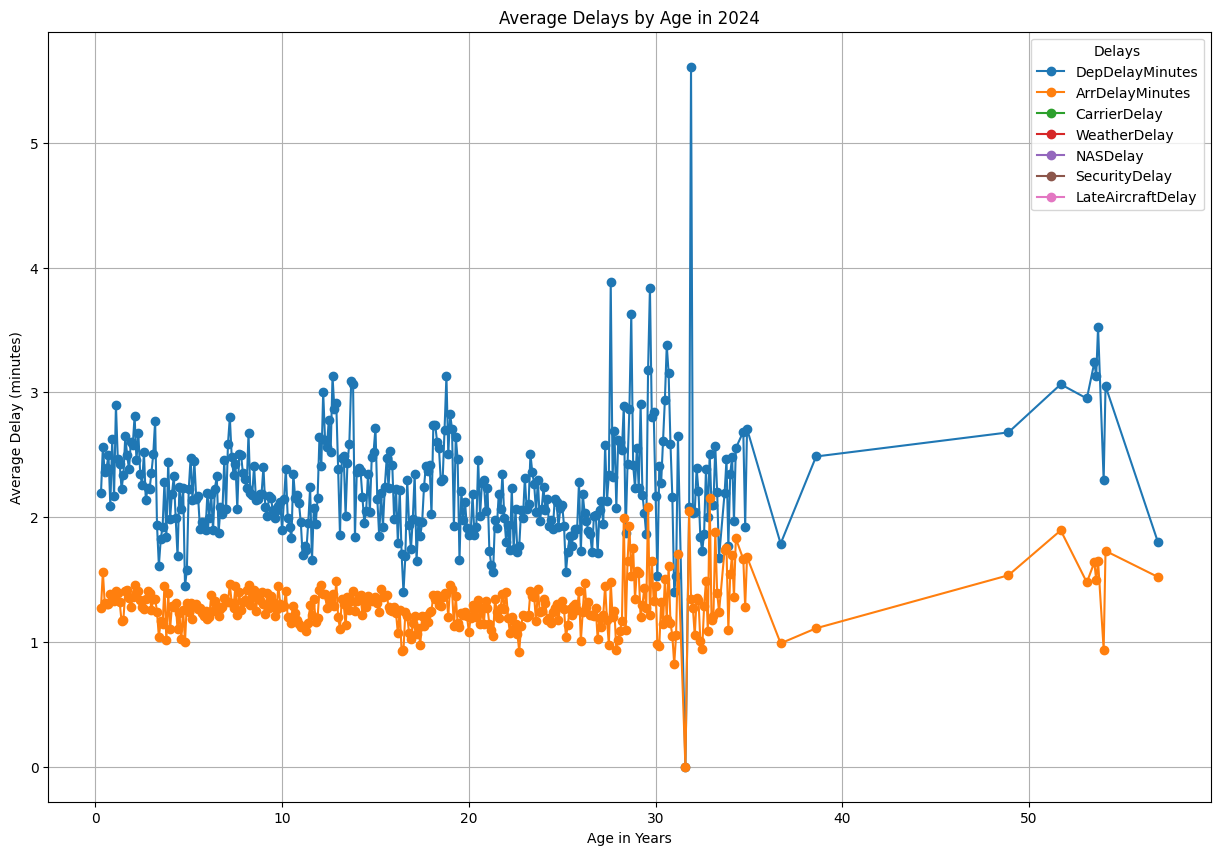

In [61]:
# ageYears vs delays

# Filter the data for 2024
data_2024 = train_data[train_data["Year"] == 2024]

# Calculate the average delays for each age
age_delays = data_2024[data_2024["ageYears"]< 500].groupby("ageYears")[delays].mean()

# Plot the average delays for each age
plt.figure(figsize=(15, 10))
age_delays.plot(kind="line", marker="o", ax=plt.gca())
plt.title("Average Delays by Age in 2024")
plt.xlabel("Age in Years")
plt.ylabel("Average Delay (minutes)")
plt.grid(True)
plt.legend(title="Delays")
plt.show()


- There are age values as high as 1800 this is clearly not correct.

Individual Attributes
=====================
\* Dervived from the other features

Air Crafts
----------
| Attribute             | Type        | Missing | Noise | Use  | Distribution             |
| --------------------- | ----------- | ------- | ----- | ---- | ------------------------ |
| id                    | Text        | None    | None  |      | Unique except 50 doubles |
| reg                   | Text        | None    | None  |      | Unique                   |
| active                | Boolean     | None    | None  |      | 93% true                 |
| serial                | Text        | 14      | None  |      | Unique                   |
| hexIcao               | Text        | 32      | None  |      | Unique                   |
| airlineName           | Categorical | None    | None  | high | Top heavy                |
| iataCodeShort         | Categorical | 2%      | None  |      | Top heavy                |
| icaoCode              | Categorical | 7%      | None  |      | Top heavy                |
| model                 | Categorical | 3%      | None  |      | Top heavy                |
| modelCode             | Categorical | 14      | None  |      | Exponential decay        |
| numSeats              | Int         | 34%     | None  |      | Loosely normal           |
| rolloutDate           | Date        | 29%     | None  |      | Unique                   |
| firstFlightDate       | Date        | 37%     | None  |      |                          |
| deliveryDate          | Date        | 17%     | None  |      |                          |
| registrationDate      | Date        | 39      | None  |      |                          |
| typeName              | Categorical | None    | None  |      | Top heavy                |
| numEngines            | Int         | 3%      | None  |      | All but 5 the same       |
| engineType            | Categorical | 3%      | None  |      | Nearly all the same      |
| isFreighter           | Boolean     | None    | None  |      | 36 Trues                 |
| productionLine        | Categorical | 2%      | None  |      | Top heavy                |
| ageYears              | Float       | 5%      | .1    |      | Peaks and Valleys        |
| verified              | Boolean     | None    | None  |      | 29 false values          |
| numRegistrations      | Int         | None    | None  |      | low value top heavy      |
| firstRegistrationDate | Date        | 30      | None  |      | Near unique              |

Summary of the individual attributes of the weather data. Many more details are available in the analysis in the subsequent cells.

| Attribute                       | Type        | Missing | Noise       | Usefulness | Distribution |
| ------------------------------- | ----------- | ------- | ----------- | ---------- | ------------ |
| Year                            | Time        | None    | None        |            | Uniform      |
| Quarter                         | Time        | None    | None        |            | Uniform      |
| Month                           | Time        | None    | None        |            | Uniform      |
| DayofMonth                      | Time        | None    | None        |            | Uniform      |
| DayofWeek                       | Time        | None    | None        |            | Uniform      |
| FlightDate                      | Time        | None    | Rounded Day | High       | Uniform      |
| Marketing_Airline_Network       | Categorical | None    | None        |            | Top Heavy    |
| Operated_or_Branded_Code...     | Categorical | None    | None        |            | Top Heavy    |
| DOT_ID_Marketing_Airline        | ID          | None    | None        |            | None         |
| IATA_Code_Marketing_Airline     | Categorical | None    | None        |            | Top Heavy    |
| Flight_Number_Marketing_Airline | ID          | None    | None        |            | None         |
| Originally_Scheduled_Code...    | Categorical | 99%     | None        | Cannot Use | None         |
| DOT_ID_Originally...            | ID          | 99%     | None        | Cannot Use | None         |
| IATA_Code_Originally...         | Categorical | 99%     | None        | Cannot Use | None         |
| Flight_Num_Originally...        | ID          | 99%     | None        | Cannot Use | None         |
| Operating_Airline               | Categorical | None    | None        |            | None         |
| DOT_ID_Operating_Airline        | ID          | None    | None        |            | None         |
| IATA_Code_Operating_Airline     | Categorical | None    | None        |            | None         |
| Tail_Number                     | ID          | None    | None        |            | Distinct     |
| Flight_Number_Operating_Airline | ID          | None    | None        |            | Distinct     |
| OriginAirportID                 | ID          | None    | None        |            | Distinct     |
| OriginAirportSeqID              | ID          | None    | None        |            | Distinct     |
| OriginCityMarketID              | ID          | None    | None        |            | None         |
| Origin                          | Categorical | None    | None        |            | None         |
| OriginCityName                  | Categorical | None    | None        |            | None         |
| OriginState                     | Categorical | None    | None        |            | None         |
| OriginStateFips                 | Categorical | None    | None        |            | None         |
| OriginStateName                 | Categorical | None    | None        |            | None         |
| OriginWac                       | Categorical | None    | None        |            | None         |
| DestAirportID                   | ID          | None    | None        |            | None         |
| DestAirportSeqID                | ID          | None    | None        |            | None         |
| DestCityMarketID                | ID          | None    | None        |            | None         |
| Dest                            | Categorical | None    | None        |            | None         |
| DestCityName                    | Categorical | None    | None        |            | None         |
| DestState                       | Categorical | None    | None        |            | None         |
| DestStateFips                   | Categorical | None    | None        |            | None         |
| DestStateName                   | Categorical | None    | None        |            | None         |
| DestWac                         | Categorical | None    | None        |            | None         |
| CRSDepTime                      | Time        | None    | None        | Cannot Use | None         |
| DepTime                         | Time        | None    | None        | Cannot Use | None         |
| DepDelay                        | Time        | None    | None        | Cannot Use | None         |
| DepDelayMinutes                 | Time        | None    | None        | Cannot Use | None         |
| DepDel15                        | ?           | None    | None        | Cannot Use | None         |
| DepartureDelayGroups            | ?           | None    | None        | Cannot Use | None         |
| DepTimeBlk                      | Time        | None    | None        | Cannot Use | None         |
| TaxiOut                         | Time        | None    | None        | Cannot Use | None         |
| WheelsOff                       | Time        | None    | None        | Cannot Use | None         |
| WheelsOn                        | Time        | None    | None        | Cannot Use | None         |
| TaxiIn                          | Time        | None    | None        | Cannot Use | None         |
| CRSArrTime                      | Time        | None    | None        | Cannot Use | None         |
| ArrTime                         | Time        | None    | None        | Cannot Use | None         |
| ArrDelay                        | Time        | None    | None        | Cannot Use | None         |
| ArrDelayMinutes                 | Time        | None    | None        | Cannot Use | None         |
| ArrDel15                        | Time        | None    | None        | Cannot Use | None         |
| ArrivalDelayGroups              | Time        | None    | None        | Cannot Use | None         |
| ArrTimeBlk                      | Time        | None    | None        | Cannot Use | None         |
| Cancelled                       | Categorical | None    | None        | Cannot Use | None         |
| CancellationCode                | Categorical | None    | None        | Cannot Use | None         |
| Diverted                        | Categorical | None    | None        | Cannot Use | None         |
| CRSElapsedTime                  | Time        | None    | None        | Cannot Use | None         |
| ActualElapsedTime               | Time        | None    | None        | Cannot Use | None         |
| AirTime                         | Time        | None    | None        | Cannot Use | None         |
| Flights                         | Time        | None    | None        | Cannot Use | All the Same |
| Distance                        | Int         | None    | Rounded int | Maybe good | Normal?      |
| DistanceGroup                   | Categorical | None    | None        | Maybe      | Normal?      |
| CarrierDelay                    | ?           | All     | None        | Cannot Use | None         |
| WeatherDelay                    | ?           | All     | None        | Cannot Use | None         |
| NASDelay                        | ?           | All     | None        | Cannot Use | None         |
| SecurityDelay                   | ?           | All     | None        | Cannot Use | None         |
| LateAircraftDelay               | ?           | All     | None        | Cannot Use | None         |
| FirstDepTime                    | Time        | >99%    | None        | Cannot Use | None         |
| TotalAddGTime                   | Time        | >99%    | None        | Cannot Use | None         |
| LongestAddGTime                 | Time        | >99%    | None        | Cannot Use | None         |
| Duplicate                       | Data Info   | None    | None        | Cannot Use | All the same |


In [80]:
train_data_dropped = train_data.drop(
    columns=['CRSDepTime','DepTime','DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut', 
             'WheelsOff', 'WheelsOn', 'TaxiIn', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 
             'ArrTimeBlk', 'Cancelled', 'CancellationCode', 'Diverted', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 
             'Flights', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'FirstDepTime', 
             'TotalAddGTime', 'LongestAddGTime', 'Duplicate', 'Unnamed: 119', 'Originally_Scheduled_Code_Share_Airline',
             'DOT_ID_Originally_Scheduled_Code_Share_Airline', 'IATA_Code_Originally_Scheduled_Code_Share_Airline', 
             'Flight_Num_Originally_Scheduled_Code_Share_Airline'])

In [81]:
train_data_dropped.shape

(2007549, 64)